## Chapter 2 : Versionning large datasets with DVC

In the first chapter of the second part of this tutorial, we saw how to install and use DVC to version code and data in a simple way.

However, our input dataset was extremely simple and could have been versionned with GIT without difficulty. 

The main objective of this second chapter is to show the true power of DVC. We will keep our objective of predicting AD vs Control subjects, but instead of assuming a simple preprocessed dataset with hypocampus volumes already extracted, we will work directly with brain images and train a deep learning model to perform this task.

The second objective of this chapter is to show some more advanced features of DVC like experiment managment.

Let's dive in !

### Setup the repo

Since this is a new notebook meant to be independant from the notebook of the first chapter, we will start a new research project from scratch.

Start by configuring the GIT and DVC repo:

In [ ]:
# Dirty for now...
! pip install git+https://github.com/aramis-lab/NOW-2023-lib.git/

In [ ]:
# If you are running on collab or if you don't have tree installed:
# ! apt-get install tree

In [1]:
! pip install dvc
! git init
! dvc init

Initialized empty Git repository in /Users/nicolas.gensollen/GitRepos/NOW-2023/notebooks/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


As with the previous notebook, you might need to configure your username and email:

In [2]:
! git config --local user.email "john.doe@inria.fr"
! git config --local user.name "John Doe"

In [3]:
! git commit -m "initialize DVC"

[main (root-commit) b9747f5] initialize DVC
 3 files changed, 6 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore


### Database

In this session we use the images from a public research project: OASIS-1. Two labels exist in this dataset:

- CN (Cognitively Normal) for healthy participants.
- AD (Alzheimer’s Disease) for patients affected by Alzheimer’s disease.

The original images were preprocessed using Clinica: a software platform for clinical neuroimaging studies.

Preprocessed images and other files are distributed in a tarball, if you haven't downloaded the images before, run the following commands to download and extract them:

In [4]:
# Only run if necessary !
#
# ! wget --no-check-certificate --show-progress https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
# ! tar -xzf OASIS-1-dataset_pt_new.tar.gz

Once downloaded, you can take a look at it:

In [5]:
from pathlib import Path

# oasis_folder = Path("./OASIS-1_dataset/")
oasis_folder = Path("/Users/nicolas.gensollen/NOW_2023/OASIS-1_dataset/")

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


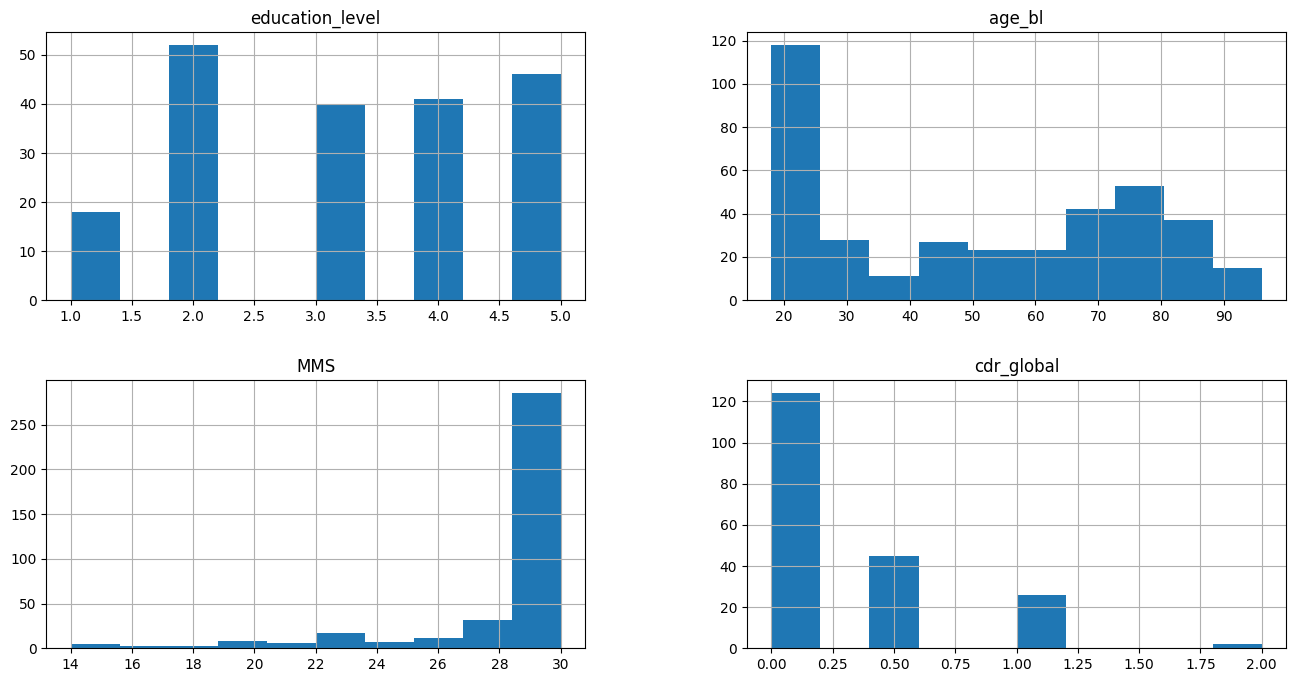

In [6]:
import pandas as pd

columns_to_use = [
    "participant_id",
    "session_id",
    "alternative_id_1",
    "sex",
    "education_level",
    "age_bl",
    "diagnosis_bl",
    "laterality",
    "MMS",
    "cdr_global",
    "diagnosis",
]
OASIS_df = pd.read_csv(
    oasis_folder / "tsv_files" / "lab_1" / "OASIS_BIDS.tsv",
    sep="\t",
    usecols=columns_to_use,
)
print(OASIS_df.head())

_ = OASIS_df.hist(figsize=(16, 8))

In [7]:
from now_2023.utils import characteristics_table

population_df = characteristics_table(OASIS_df, OASIS_df)
population_df

,N,age,%sexF,education,MMS,CDR=0,CDR=0.5,CDR=1,CDR=2
AD,73,77.5 ± 7.4,63.0,2.7 ± 1.3,22.7 ± 3.6,0,45,26,2
CN,304,44.0 ± 23.3,62.2,3.5 ± 1.2,29.7 ± 0.6,124,0,0,0


### Preprocessing

Theoretically, the main advantage of deep learning methods is to be able to work without extensive data preprocessing. However, as we have only a few images to train the network in this lab session, the preprocessing here is very extensive. More specifically, the images encountered:

- Non-linear registration.
- Segmentation of grey matter.
- Conversion to tensor format (.pt).

As mentioned above, to obtain the preprocessed images, we used some pipelines provided by Clinica and ClinicaDL in order to:

- Convert the original dataset to BIDS format ([clinica convert oasis-2-bids](https://aramislab.paris.inria.fr/docs/public/latest/Converters/OASIS2BIDS/)).
- Get the non-linear registration and segmentation of grey mater (pipeline [t1-volume](https://aramislab.paris.inria.fr/docs/public/latest/Pipelines/T1_Volume/)).
- Obtain the preprocessed images in tensor format ([tensor extraction using ClinicaDL, clinicadl extract](https://clinicadl.readthedocs.io/en/stable/Preprocessing/Extract/)).
- The preprocessed images are store in the [CAPS folder structure](http://www.clinica.run/doc/CAPS/Introduction/) and all have the same size (121x145x121).

To facilitate the training and avoid overfitting due to the limited amount of data, the model won’t use the full image but only a part of the image (size 30x40x30) centered on a specific neuroanatomical region: the hippocampus (HC). This structure is known to be linked to memory, and is atrophied in the majority of cases of Alzheimer’s disease patients.

Before going further, let's take a look at the images we have downloaded and let's compute a cropped image of the left HC for a randomly selected subject:

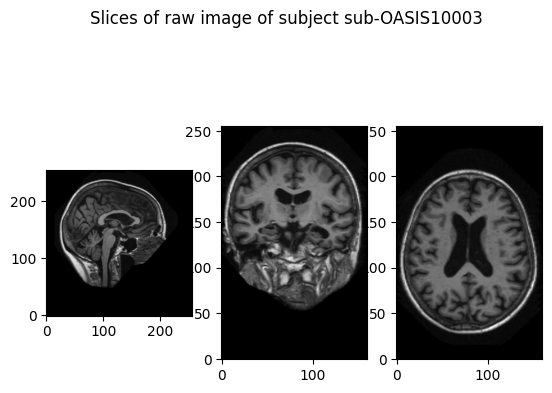

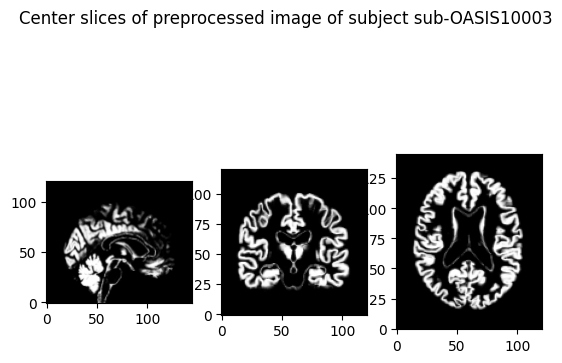

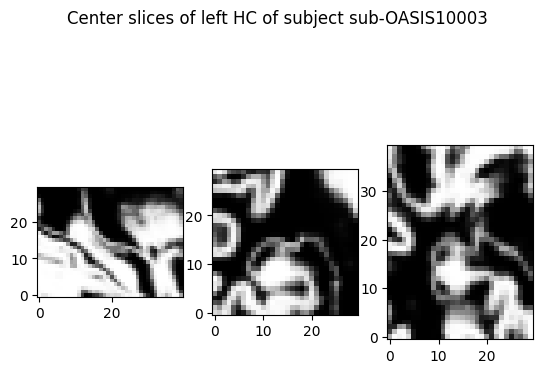

In [8]:
import torch
from now_2023.plotting import plot_image, plot_tensor
from now_2023.utils import CropLeftHC

subject = 'sub-OASIS10003'
image_folder = (
    oasis_folder /
    "CAPS" /
    "subjects" /
    subject /
    "ses-M00" /
    "deeplearning_prepare_data" /
    "image_based" /
    "custom"
)
image_filename = f"{subject}_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt"
preprocessed_pt = torch.load(image_folder / image_filename)

plot_image(
    oasis_folder / "raw" / f"{subject}_ses-M00_T1w.nii.gz",
    cut_coords=(78, 122, 173),
    title=f'Slices of raw image of subject {subject}',
)
plot_tensor(
    preprocessed_pt,
    cut_coords=(60, 72, 60),
    title=f'Center slices of preprocessed image of subject {subject}',
)
plot_tensor(
    CropLeftHC()(preprocessed_pt),
    cut_coords=(15, 20, 15),
    title=f'Center slices of left HC of subject {subject}',
)

## Use only the left HC

We are going to generate a new dataset consisting only of images of the left hippocampus (the last image above). 

For simplicity, this is the dataset that we will consider as our input dataset, and thus the dataset we will version. In other word, we will assume that we didn't computed the cropped images from the raw dataset downloaded above, but versioning the raw dataset would work in the same way.

Note also that to improve the training and reduce overfitting, we can add a random shift to the cropping function. This means that the bounding box around the hippocampus may be shifted by a limited amount of voxels in each of the three directions.

Let's generate our dataset:

In [9]:
from now_2023.data_generation import generate_cropped_hc_dataset

data_folder = Path("./data")

generate_cropped_hc_dataset(
    oasis_folder,
    hemi="left",
    output_folder=data_folder,
    verbose=False,
)

This should have created a new `data` folder in the current working space, which should have the following structure:

In [10]:
! tree data | head -n 14

data
└── subjects
    ├── sub-OASIS10001
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   └── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    ├── sub-OASIS10002
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   └── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt


As you can see, we have one tensor image for each subject, representing the extracted left hippocampus.

Let's take a look at some of these images:

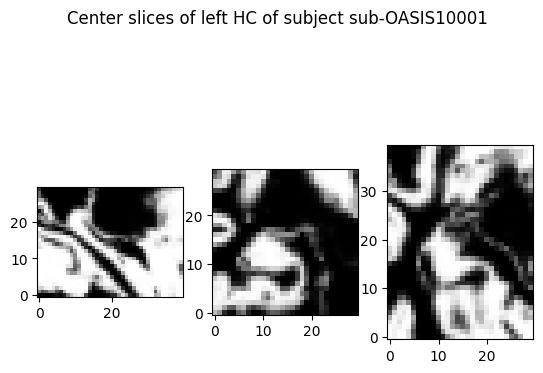

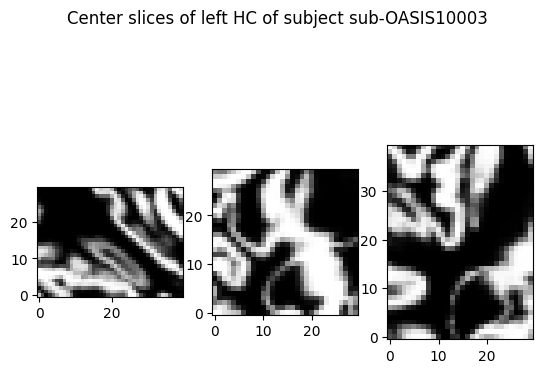

In [11]:
from now_2023.plotting import plot_hc

plot_hc(data_folder, 'sub-OASIS10001', "left", cut_coords=(15, 20, 15))
plot_hc(data_folder, 'sub-OASIS10003', "left", cut_coords=(10, 30, 25))

### Cross-validation

In order to choose hyperparameters the set of images is divided into a training set (80%) and a validation set (20%). The data split was performed in order to ensure a similar distribution of diagnosis, age and sex between the subjects of the training set and the subjects of the validation set. Moreover the MMS distribution of each class is preserved.

In [12]:
train_df = pd.read_csv(oasis_folder / "tsv_files" / "lab_1" / "train.tsv", sep="\t")
valid_df = pd.read_csv(oasis_folder / "tsv_files" / "lab_1" / "validation.tsv", sep="\t")
train_df["hemi"] = "left"
valid_df["hemi"] = "left"

train_population_df = characteristics_table(train_df, OASIS_df)
valid_population_df = characteristics_table(valid_df, OASIS_df)

print(f"Train dataset:\n {train_population_df}\n")
print(f"Validation dataset:\n {valid_population_df}")

Train dataset:
       N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   58   77.4 ± 7.5  69.0  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  242  43.4 ± 23.5  62.0  3.6 ± 1.2  29.8 ± 0.5    97       0     0     0

Validation dataset:
      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15   78.2 ± 6.6  40.0  2.5 ± 1.0  22.9 ± 3.6     0       8     7     0
CN  62  46.3 ± 22.6  62.9  3.4 ± 1.3  29.6 ± 0.7    27       0     0     0


### Model

We propose here to design a convolutional neural network that takes for input a patch centered on the left hippocampus of size 30x40x30.

The architecture of the network was found using a Random Search on architecture + optimization hyperparameters.

In [13]:
import json
from now_2023.models import CNNModel

model = CNNModel(learning_rate=10**-4, n_epochs=30, batch_size=4)
model.fit(data_folder, train_df)

results_training_left, metrics_training_left = model.predict(data_folder, train_df)
results_validation_left, metrics_validation_left = model.predict(data_folder, valid_df)

print(f"Metrics on training set :\n{json.dumps(metrics_training_left, indent=4)}")
print(f"Metrics on validation set :\n{json.dumps(metrics_validation_left, indent=4)}")

Epoch 0: loss = 0.3366, balanced accuracy = 0.5086
Epoch 1: loss = 0.2435, balanced accuracy = 0.8021
Epoch 2: loss = 0.2030, balanced accuracy = 0.7804
Epoch 3: loss = 0.1795, balanced accuracy = 0.7959
Epoch 4: loss = 0.1814, balanced accuracy = 0.7738
Epoch 5: loss = 0.1840, balanced accuracy = 0.7586
Epoch 6: loss = 0.1716, balanced accuracy = 0.9607
Epoch 7: loss = 0.1245, balanced accuracy = 0.9597
Epoch 8: loss = 0.1172, balanced accuracy = 0.8966
Epoch 9: loss = 0.1046, balanced accuracy = 0.9790
Epoch 10: loss = 0.0933, balanced accuracy = 0.9614
Epoch 11: loss = 0.0859, balanced accuracy = 0.9635
Epoch 12: loss = 0.1622, balanced accuracy = 0.9545
Epoch 13: loss = 0.0993, balanced accuracy = 0.8793
Epoch 14: loss = 0.0647, balanced accuracy = 0.9979
Epoch 15: loss = 0.0584, balanced accuracy = 0.9914
Epoch 16: loss = 0.0541, balanced accuracy = 1.0000
Epoch 17: loss = 0.0576, balanced accuracy = 0.9914
Epoch 18: loss = 0.0501, balanced accuracy = 1.0000
Epoch 19: loss = 0.041

Let's save the model and validation metrics:

In [14]:
model.save("model.h5")
with open("metrics.json", "w") as fp:
    json.dump(metrics_validation_left, fp, indent=4)

We can now version both the data used for training and validation as well as the trained model:

In [15]:
! dvc add data
! dvc add model.h5

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/Users/nicolas.gensollen/GitRepos/NOW-2023/notebooks/.dv
                                                                                
!
  0%|          |Adding data to cache                  0/? [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
 82%|████████▏ |Adding data to cache        343/416 [00:00<00:00, 3427.05file/s]
                                                                                
!
  0%|          |Checking out /Users/nicolas.gensollen/0/? [00:00<?,    ?files/s]
  0%|          |Checking out /Users/nicolas.gensolle0/417 [00:00<?,    ?files/s]
 38%|███▊      |Checking out /Users/nico

In [17]:
! git add model.h5.dvc .gitignore data.dvc metrics.json
! git commit -m "First model, trained with images cropped around left HC"
! git tag -a "v1.0" -m "model v1.0, left HC only"

[main b0ef919] First model, trained with images cropped around left HC
 4 files changed, 20 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 data.dvc
 create mode 100644 metrics.json
 create mode 100644 model.h5.dvc


In [18]:
! git log

commit b0ef9195dda42326d368e057d688cfaebe0a3893 (HEAD -> main, tag: v1.0)
Author: John Doe <john.doe@inria.fr>
Date:   Fri Nov 10 18:06:06 2023 +0100

    First model, trained with images cropped around left HC

commit b9747f5bf453368fd05d8f76930513aae99b0301
Author: John Doe <john.doe@inria.fr>
Date:   Fri Nov 10 17:59:54 2023 +0100

    initialize DVC


## Use both the left and right HC

Let's imagine now that we receive additional data in the form of cropped images of the right HC.

Of course we are only pretending here, recall that we can easily generate these images from the downloaded dataset:

In [19]:
generate_cropped_hc_dataset(oasis_folder, hemi="right", output_folder=Path("./data"), verbose=False)

In [20]:
! tree data | head -n 16

data
└── subjects
    ├── sub-OASIS10001
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   ├── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    │                   └── sub-OASIS10001_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_right.pt
    ├── sub-OASIS10002
    │   └── ses-M00
    │       └── deeplearning_prepare_data
    │           └── image_based
    │               └── custom
    │                   ├── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_left.pt
    │                   └── sub-OASIS10002_ses-M00_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability_right.pt


As you can see, we now have two images for each subject, one for the left HC that we already had in the previous section, and one for the right HC that we just generated.

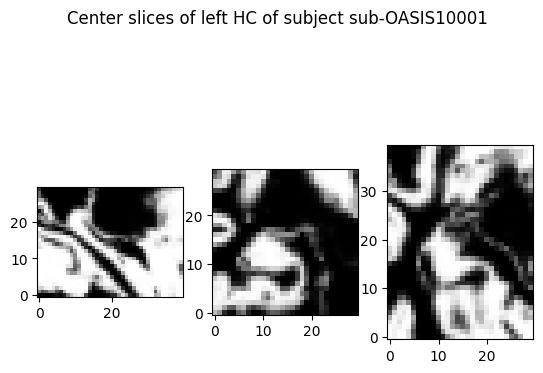

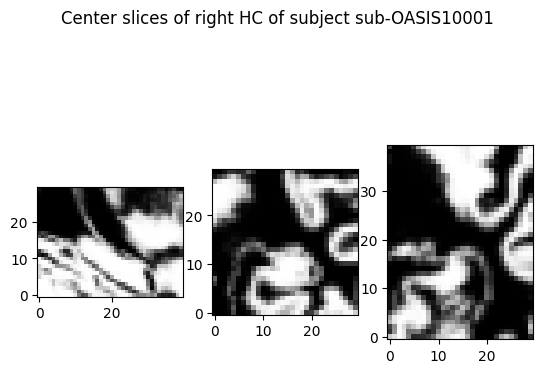

In [21]:
plot_hc(data_folder, 'sub-OASIS10001', "left", cut_coords=(15, 20, 15))
plot_hc(data_folder, 'sub-OASIS10001', "right", cut_coords=(15, 20, 15))

We need to update our train and validation dataframes to encode this:

In [22]:
import numpy as np

train_df = train_df.loc[np.repeat(train_df.index, 2)].reset_index(drop=True)
train_df["hemi"][::2] = "right"
valid_df = valid_df.loc[np.repeat(valid_df.index, 2)].reset_index(drop=True)
valid_df["hemi"][::2] = "right"
train_df

,participant_id,session_id,diagnosis,hemi
0,sub-OASIS10003,ses-M00,AD,right
1,sub-OASIS10003,ses-M00,AD,left
2,sub-OASIS10021,ses-M00,AD,right
3,sub-OASIS10021,ses-M00,AD,left
4,sub-OASIS10022,ses-M00,AD,right
...,...,...,...,...
595,sub-OASIS10406,ses-M00,CN,left
596,sub-OASIS10313,ses-M00,CN,right
597,sub-OASIS10313,ses-M00,CN,left
598,sub-OASIS10090,ses-M00,CN,right


We can now instantiate a new `CNNModel` and train it on both HC:

In [23]:
model = CNNModel(learning_rate=10**-4, n_epochs=30, batch_size=4)
model.fit(data_folder, train_df)

results_training_both, metrics_training_both = model.predict(data_folder, train_df)
results_validation_both, metrics_validation_both = model.predict(data_folder, valid_df)

print(f"Metrics on training set :\n{json.dumps(metrics_training_both, indent=4)}")
print(f"Metrics on validation set :\n{json.dumps(metrics_validation_both, indent=4)}")

Epoch 0: loss = 0.3437, balanced accuracy = 0.5152
Epoch 1: loss = 0.2657, balanced accuracy = 0.6943
Epoch 2: loss = 0.3019, balanced accuracy = 0.5864
Epoch 3: loss = 0.2003, balanced accuracy = 0.8328
Epoch 4: loss = 0.2055, balanced accuracy = 0.9240
Epoch 5: loss = 0.1754, balanced accuracy = 0.8412
Epoch 6: loss = 0.1720, balanced accuracy = 0.9194
Epoch 7: loss = 0.1536, balanced accuracy = 0.8743
Epoch 8: loss = 0.1564, balanced accuracy = 0.9356
Epoch 9: loss = 0.1511, balanced accuracy = 0.8085
Epoch 10: loss = 0.1466, balanced accuracy = 0.8095
Epoch 11: loss = 0.1682, balanced accuracy = 0.7619
Epoch 12: loss = 0.1238, balanced accuracy = 0.8526
Epoch 13: loss = 0.1844, balanced accuracy = 0.9471
Epoch 14: loss = 0.1117, balanced accuracy = 0.8622
Epoch 15: loss = 0.0977, balanced accuracy = 0.9804
Epoch 16: loss = 0.0850, balanced accuracy = 0.9559
Epoch 17: loss = 0.2337, balanced accuracy = 0.9329
Epoch 18: loss = 0.0705, balanced accuracy = 0.9905
Epoch 19: loss = 0.063

In [24]:
model.save("model.h5")
with open("metrics.json", "w") as fp:
    json.dump(metrics_validation_left, fp, indent=4)

In [25]:
! dvc add data
! dvc add model.h5

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/Users/nicolas.gensollen/GitRepos/NOW-2023/notebooks/.dv
                                                                                
!
  0%|          |Adding data to cache                  0/? [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
  0%|          |Adding data to cache                0/416 [00:00<?,     ?file/s]
 98%|█████████▊|Adding data to cache        407/416 [00:00<00:00, 4067.03file/s]
                                                                                
!
  0%|          |Checking out /Users/nicolas.gensollen/0/? [00:00<?,    ?files/s]
  0%|          |Checking out /Users/nicolas.gensolle0/833 [00:00<?,    ?files/s]
 23%|██▎       |Checking out /Users/nico

In [26]:
! git add model.h5.dvc data.dvc metrics.json
! git commit -m "Second model, trained with images cropped around left and right HC"
! git tag -a "v2.0" -m "model v2.0, left and right HC"

[main 429d5d8] Second model, trained with images cropped around left and right HC
 2 files changed, 4 insertions(+), 4 deletions(-)


In [27]:
! git log

commit 429d5d8f185ed59bb197af4b6bfeac4546ac0674 (HEAD -> main, tag: v2.0)
Author: John Doe <john.doe@inria.fr>
Date:   Fri Nov 10 18:37:26 2023 +0100

    Second model, trained with images cropped around left and right HC

commit b0ef9195dda42326d368e057d688cfaebe0a3893 (tag: v1.0)
Author: John Doe <john.doe@inria.fr>
Date:   Fri Nov 10 18:06:06 2023 +0100

    First model, trained with images cropped around left HC

commit b9747f5bf453368fd05d8f76930513aae99b0301
Author: John Doe <john.doe@inria.fr>
Date:   Fri Nov 10 17:59:54 2023 +0100

    initialize DVC


Cleaning:

In [28]:
# Do not run this unless you want to start over from scratch...
! rm model.*
! rm -rf .git
! rm -rf .dvc
! rm .gitignore
! rm .dvcignore
! rm metrics.json
! rm data.dvc
! rm -r data